# Latihan-11 2D Conceptual Model

Latihan ini contoh pemodelan 2D model menggunakan horizon model dari eksternal files
<br><br> _citation for this page: "Adi Widyantoro, 2021, Pertamina Seismic QI Course, Latihan-11 2D Conceptual Model, accessed MM DD, YYYY."_  
<br>
>(update terakhir tanggal 1 Agustus 2021 oleh Adi Widyantoro)
<hr>

<br> Diperlukan dependencies: Vpstk1.npy, Vsstk1.npy, dan Rhostk1.npy
<br> file format:

|inline|TWT |
|:-    |:--:|
|0|239  |
|1|242  |
|2|...|

<br> file dalam folder sebaiknya diurutkan dan dierikan dummy top dan base
<br> 01dummytop.txt
<br> 02horz1.txt
<br> ...
<br> 99dummybase.txt

In [21]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import scipy as sp
import scipy.ndimage as snd
import copy
import os
import pandas as pd
from scipy.interpolate import interp1d

In [18]:
cd horizon

[WinError 2] The system cannot find the file specified: 'horizon'
C:\Users\HP\Documents\python\01_pheclass\horizon


In [22]:
pwd

'C:\\Users\\HP\\Documents\\python\\01_pheclass\\horizon'

In [23]:
# PENTING!!: filename dalam folder harus diurutkan dari top ke base
filenames = [f for f in os.listdir('.') if os.path.isfile(f)]
data = pd.DataFrame(columns = ['Inline', 'TWT', 'Horz'])
n = 0
for file in filenames:
    df = pd.read_table(file, header=0, encoding='utf-8', names=['Inline', 'TWT'])
    df['Inline'] = df['Inline']
    df['TWT'] = df['TWT']
    df['Horz']= filenames[n]
    data = data.append(df)
    n+=1

In [24]:
# pastikan jumlah horizon termasuk dummy top dan base
len(filenames)

6

In [14]:
# QC data
print(data)

   Inline  TWT        Horz
0       0  100   01top.txt
1       1  100   01top.txt
2       2  100   01top.txt
3       3  100   01top.txt
4       4  100   01top.txt
..    ...  ...         ...
95     95  500  06base.txt
96     96  500  06base.txt
97     97  500  06base.txt
98     98  500  06base.txt
99     99  500  06base.txt

[600 rows x 3 columns]


## Boundaries

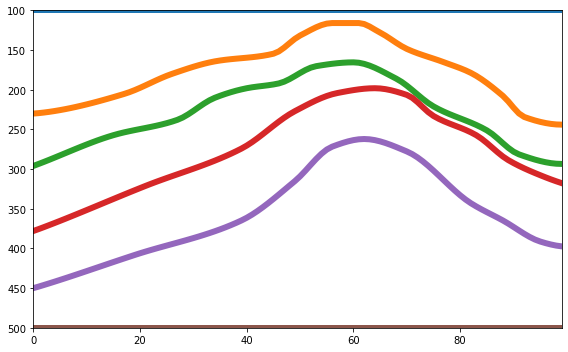

In [27]:
# grup multiple horizon ke dalam satu file dan QC display. Note: termasuk dummy top dan base

grouped = data.groupby(['Horz'],sort=True) 
#Plot In-line view
plt.figure(figsize=(8,5))
n = 0
for group in grouped:
  plt.plot(group[1]['Inline'], group[1]['TWT'], lw=6)
  n+=1
plt.ylim(100,500)
plt.gca().invert_yaxis(); 
plt.margins(0,0)
plt.tight_layout()

In [28]:
iline=group[1]['Inline']
time=group[1]['TWT']
ncellx=len(iline)
ncelly=len(time)
print(ncellx,ncelly)
model = np.zeros(shape = (ncellx, ncelly), dtype=np.int)

100 100


## Grid dan Build Earth Model (AI)

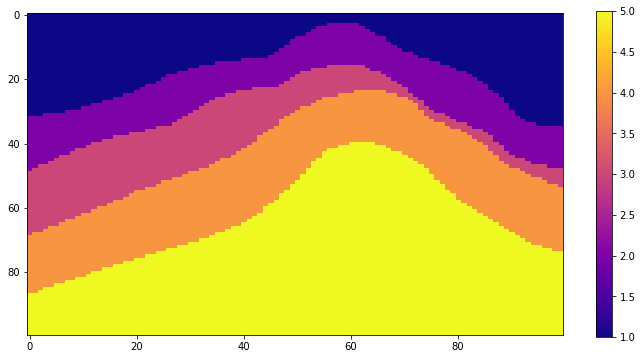

In [29]:
def regrid(x, x_min, x_max, out_min, out_max):
    mapped = ((x - x_min) * (out_max - out_min) // (x_max - x_min) + out_min).astype(int)
    z = mapped
    return z
n = 0
for group in grouped:
    layer = regrid(group[1]['TWT'].values, 100, 500, 0, ncellx)
    x = np.arange(0, len(layer), 1)
    # Interpolate to fill gaps
    intpl = interp1d(x, layer, kind='nearest')
    x_new = np.arange(0,ncellx,1).astype('int')
    layer_new = intpl(x_new).astype('int')
    #For the first layer
    if n == 0:
      layer_n = np.zeros_like(x_new)
    #For the last layer
    if n == len(filenames)+1:
      layer_new = np.zeros_like(x_new) + ncelly
    #Fill trace by trace
    for i in range(len(x_new)):
      model[layer_n[i]:layer_new[i],x_new[i]] = n
    layer_n = layer_new
    n += 1

plt.figure(figsize=(12,6))
plt.imshow(model,cmap = 'plasma', aspect=0.6); plt.colorbar()
plt.show()

In [10]:
#Create model filled with AI atau indidvidual Vp, Rho
model_AI  = np.copy(model)
model_AI[model_AI == 1] = 2000*2.98
model_AI[model_AI == 2] = 2500*2.75
model_AI[model_AI == 3] = 3000*2.14
model_AI[model_AI == 4] = 3400*2.69
model_AI[model_AI == 5] = 5000*3.05

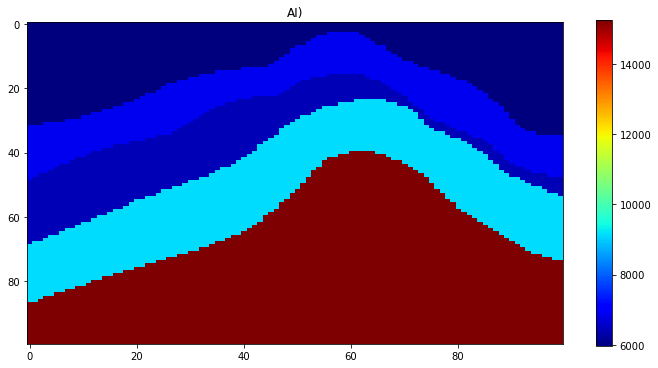

In [11]:
plt.figure(figsize=(12,6))
plt.imshow(model_AI, cmap = 'jet', aspect=0.6)
plt.title('AI)'); plt.colorbar(); plt.show()

## Reflection Coefficient

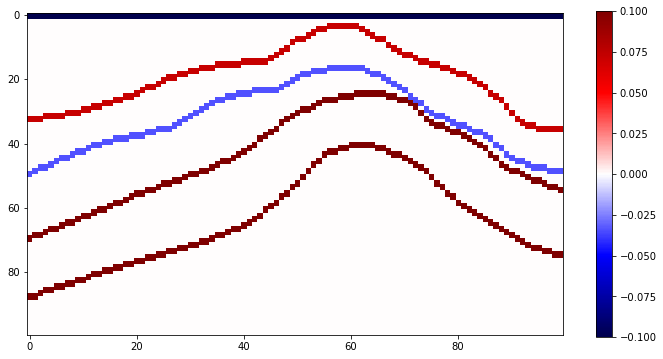

In [12]:
#Calculate Reflection Coefficient
width = 2
rc = (model_AI - np.roll(model_AI, width, axis=0))/(model_AI + np.roll(model_AI, width, axis=0))
plt.figure(figsize=(12,6))
plt.imshow(rc, cmap='seismic', aspect=0.6, vmin=-0.1, vmax=0.1)
plt.colorbar(); plt.show()

## WAVELET

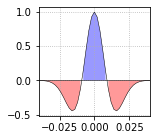

In [13]:
from scipy.signal import hilbert
#statistics
# statwavelet = np.genfromtxt('isolatedsands/wavelet.txt')
# w, t = statwavelet[:,1], statwavelet[:,0]
# plt.plot(t, w)
#Ricker
f, l, dt, ph = 25, 200, 2, 0
t = np.arange(-l/2, l/2, dt)/1000
# t = np.linspace(-l/2, (l-dt)/2, int(l/dt))/1000
zerophase = (1.0 - 2.0*(np.pi**2)*(f**2)*(t**2)) * np.exp(-(np.pi**2)*(f**2)*(t**2))
h = hilbert (zerophase)
theta = ph*np.pi/180
wavelet = np.cos(theta)*h.real-np.sin(theta)*h.imag
plt.subplots(figsize=(2,2))
plt.plot(t,wavelet,'k', lw=0.5); plt.axhline(0, color='k', lw=0.5)
plt.fill_between(t,wavelet,0, where=wavelet>=0, color='b', alpha=0.4, lw=0); 
plt.fill_between(t,wavelet,0, where=wavelet<0, color='r', alpha=0.4, lw=0); 
plt.grid(True,linestyle=':'); plt.xlim(-0.04,0.04)
plt.show()

## CONVOLUTIONAL ZERO INCIDENT SYNTHETIC

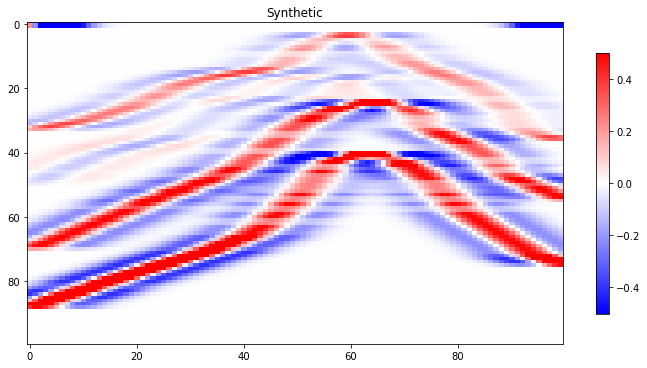

In [14]:
synth = np.array([np.apply_along_axis(lambda t: np.convolve(t, wavelet, mode='same'), axis=0,
                             arr=r) for r in rc ])
plt.figure(figsize=(12,6))
plt.imshow(synth, cmap = 'bwr', aspect=0.6, vmin=-0.5, vmax=0.5)
plt.title('Synthetic'); plt.margins(0,0)
plt.colorbar(shrink=.8); plt.show()

## SMOOTHED SYNTHETIC

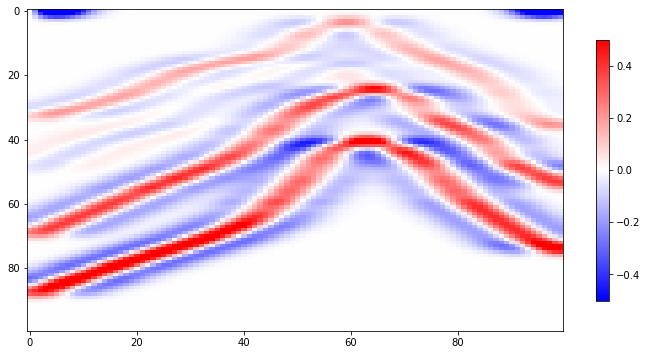

In [15]:
smoothsyn = sp.ndimage.gaussian_filter(synth, sigma=1.1)
plt.figure(figsize=(12,6))
plt.imshow(smoothsyn, cmap = 'bwr', aspect=0.6, vmin=-0.5, vmax=0.5)
plt.colorbar(shrink=.8); plt.show()

## Synthetic with Gaussian Noise 

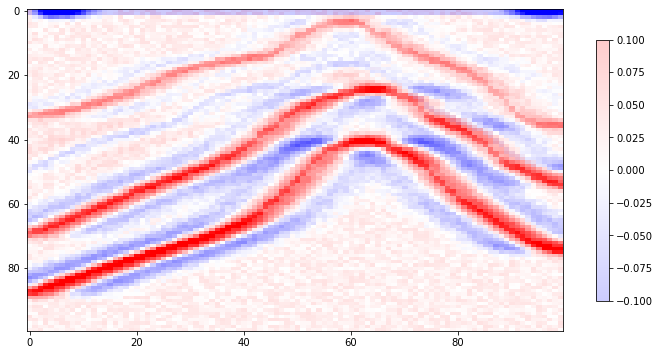

In [16]:
noisysyn = smoothsyn + 0.5 * smoothsyn.std() * np.random.random(smoothsyn.shape)
plt.figure(figsize=(12,6))
plt.imshow(noisysyn, cmap = 'bwr', aspect=0.6, vmin=-0.5, vmax=0.5)
plt.imshow(rc, cmap='bwr', aspect=0.6, vmin=-0.1, vmax=0.1, alpha=0.2)
plt.colorbar(shrink=.8); plt.show()

## FAULTED AI

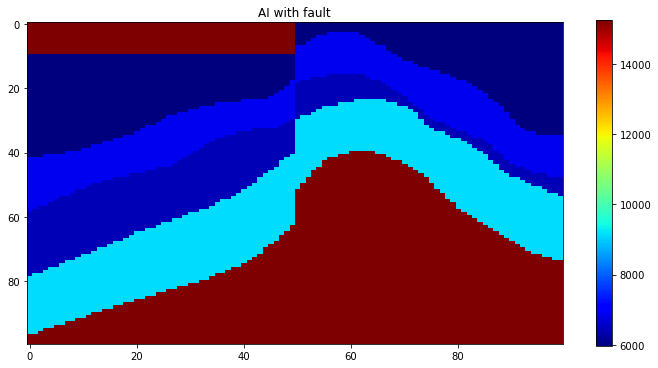

In [19]:
#@title Add Fault { output-height: 200, form-width: "300px", display-mode: "form" }
faulted_AI = copy.deepcopy(model_AI)
fault_throw1 = 10 #@param {type:"integer"}
fault_position1 = 50 #@param {type:"integer"}
fault  = np.arange(fault_position1)
with_fault = np.roll(faulted_AI[:,0:fault_position1], fault_throw1, axis=0)
with_fault = np.hstack([with_fault, faulted_AI[:, fault_position1:]])
faulted_AI = with_fault
plt.figure(figsize=(12,6))
plt.imshow(faulted_AI, cmap = 'jet', aspect=0.6)
plt.title('AI with fault'); plt.colorbar(); plt.show()

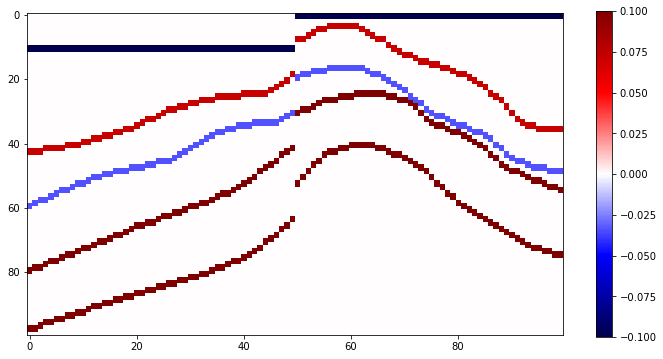

In [20]:
#Calculate Reflection Coefficient
width = 2
rcfault = (faulted_AI - np.roll(faulted_AI, width, axis=0))/(faulted_AI + np.roll(faulted_AI, width, axis=0))
plt.figure(figsize=(12,6))
plt.imshow(rcfault, cmap='seismic', aspect=0.6, vmin=-0.1, vmax=0.1)
plt.colorbar(); plt.show()

## FAULTED SYNTHETIC

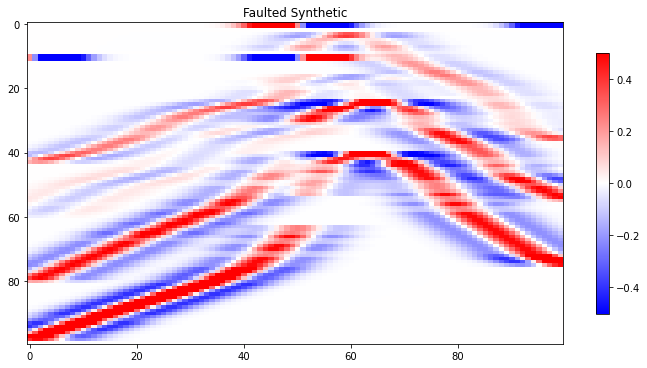

In [21]:
synthfault = np.array([np.apply_along_axis(lambda t: np.convolve(t, wavelet, mode='same'), axis=0,
                             arr=r) for r in rcfault ])
plt.figure(figsize=(12,6))
plt.imshow(synthfault, cmap = 'bwr', aspect=0.6, vmin=-0.5, vmax=0.5)
plt.title('Faulted Synthetic'); plt.margins(0,0)
plt.colorbar(shrink=.8); plt.show()

## SMOOTHED SYNTHETIC

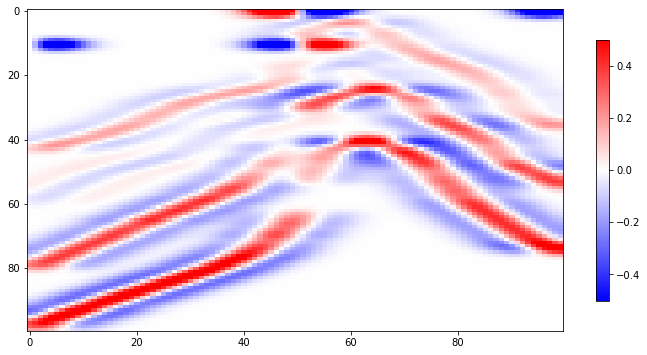

In [22]:
smoothsynfault = sp.ndimage.gaussian_filter(synthfault, sigma=1.1)
plt.figure(figsize=(12,6))
plt.imshow(smoothsynfault, cmap = 'bwr', aspect=0.6, vmin=-0.5, vmax=0.5)
plt.colorbar(shrink=.8); plt.show()

## Faulted Synthetic with Gaussian Noise 

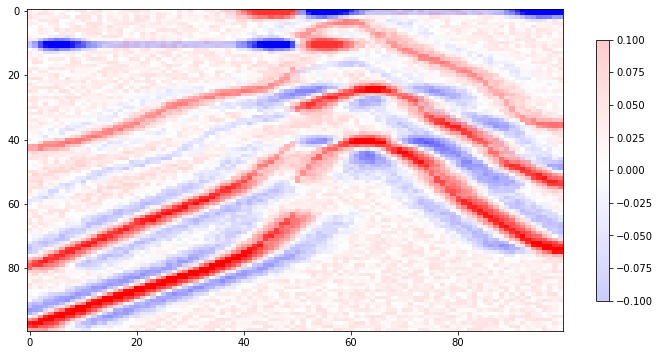

In [23]:
noisyfault = smoothsynfault + 0.5 * smoothsynfault.std() * np.random.random(smoothsynfault.shape)
plt.figure(figsize=(12,6))
plt.imshow(noisyfault, cmap = 'bwr', aspect=0.6, vmin=-0.5, vmax=0.5)
plt.imshow(rcfault, cmap='bwr', aspect=0.6, vmin=-0.1, vmax=0.1, alpha=0.2)
plt.colorbar(shrink=.8); plt.show()

## FAULTING EXPERIMENTS

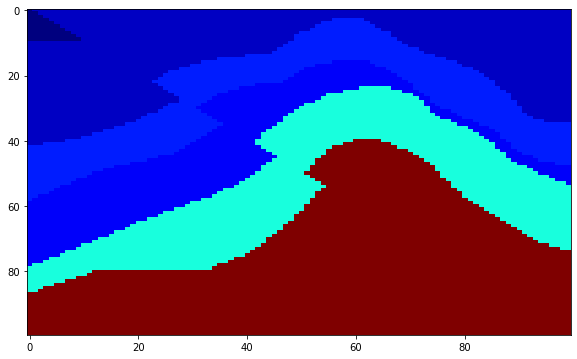

In [53]:
unshifted = copy.deepcopy(model_AI)
shifted = sp.ndimage.interpolation.shift(unshifted, (10,0), cval=unshifted[0,-1]*0.9)
unshifted[np.tril_indices(80)] = shifted[np.tril_indices(80)] # triu upper triangular, tril lower triangular
with_fault = np.hstack([unshifted])
test2 = with_fault
plt.figure(figsize=(12,6))
plt.imshow(test2, cmap = 'jet', aspect=0.6); plt.show()

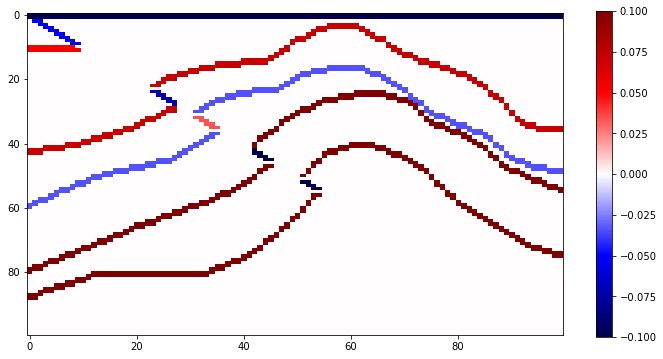

In [58]:
#Calculate Reflection Coefficient
width = 2
rctest2 = (test2 - np.roll(test2, width, axis=0))/(test2 + np.roll(test2, width, axis=0))
plt.figure(figsize=(12,6))
plt.imshow(rctest2, cmap='seismic', aspect=0.6, vmin=-0.1, vmax=0.1)
plt.colorbar(); plt.show()

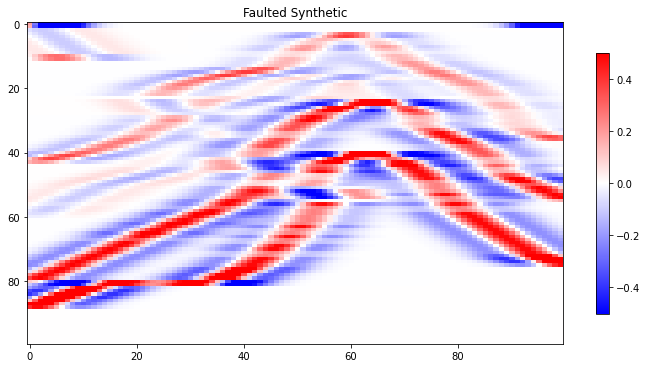

In [59]:
synthtest2 = np.array([np.apply_along_axis(lambda t: np.convolve(t, wavelet, mode='same'), axis=0,
                             arr=r) for r in rctest2 ])
plt.figure(figsize=(12,6))
plt.imshow(synthtest2, cmap = 'bwr', aspect=0.6, vmin=-0.5, vmax=0.5)
plt.title('Faulted Synthetic'); plt.margins(0,0)
plt.colorbar(shrink=.8); plt.show()

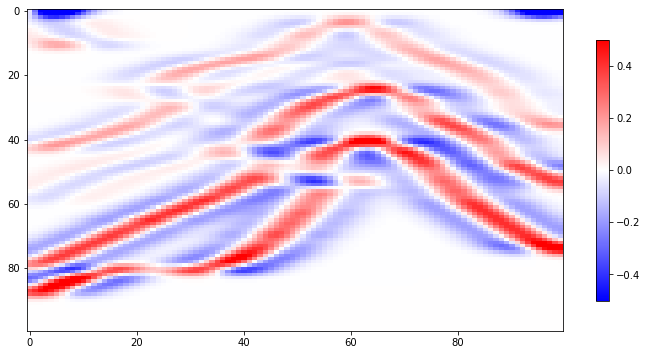

In [60]:
smoothsyntest2 = sp.ndimage.gaussian_filter(synthtest2, sigma=1.1)
plt.figure(figsize=(12,6))
plt.imshow(smoothsyntest2, cmap = 'bwr', aspect=0.6, vmin=-0.5, vmax=0.5)
plt.colorbar(shrink=.8); plt.show()

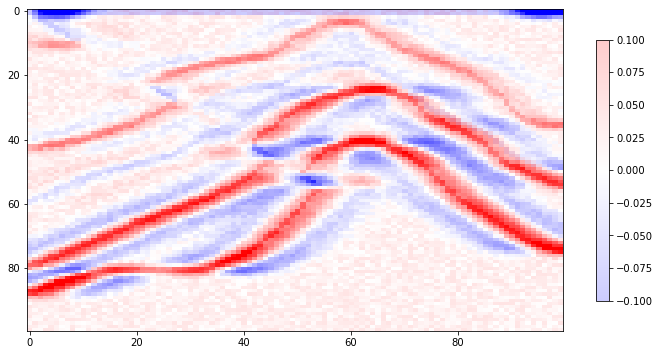

In [61]:
noisytest2 = smoothsyntest2+ 0.5 * smoothsyntest2.std() * np.random.random(smoothsyntest2.shape)
plt.figure(figsize=(12,6))
plt.imshow(noisytest2, cmap = 'bwr', aspect=0.6, vmin=-0.5, vmax=0.5)
plt.imshow(rctest2, cmap='bwr', aspect=0.6, vmin=-0.1, vmax=0.1, alpha=0.2)
plt.colorbar(shrink=.8); plt.show()

<h1><center>-Akhir Program Latihan-11-<center></h1>